In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import tensorflow_datasets as tfds
from IPython.display import display
from PIL import Image
import pathlib
import random
import pickle
import time
import json
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data


In [3]:
df = pd.read_pickle("/content/drive/MyDrive/APS360/Data/formatted_800x600.pickle")

In [ ]:
LABELS = {
    "red blood cell": 1, 
    "leukocyte": 1, 
    "gametocyte": 0, 
    "trophozoite": 0, 
    "schizont": 0, 
    "ring": 0, 
    "difficult": 0
}

In [4]:
df.head()

,image,objects,targets
0,"[[[215, 226, 220], [220, 228, 223], [219, 234,...","{'boxes': [[tensor(0.8394), tensor(0.6367), te...","{'boxes': [[tensor(335.7500), tensor(191.), te..."
1,"[[[71, 84, 135], [83, 97, 151], [98, 113, 166]...","{'boxes': [[tensor(0.7588), tensor(0.5542), te...","{'boxes': [[tensor(303.5000), tensor(166.2500)..."
2,"[[[216, 229, 216], [195, 206, 200], [172, 186,...","{'boxes': [[tensor(0.1600), tensor(0.2775), te...","{'boxes': [[tensor(64.), tensor(83.2500), tens..."
3,"[[[206, 218, 218], [203, 210, 222], [174, 171,...","{'boxes': [[tensor(0.1894), tensor(0.2225), te...","{'boxes': [[tensor(75.7500), tensor(66.7500), ..."
4,"[[[250, 250, 250], [250, 250, 250], [253, 253,...","{'boxes': [[tensor(0.2412), tensor(0.2933), te...","{'boxes': [[tensor(96.5000), tensor(88.), tens..."


In [ ]:
try: df = df.drop(columns=["imgpath", "imgshape"])
except: pass
df.columns

Index(['image', 'objects', 'targets'], dtype='object')

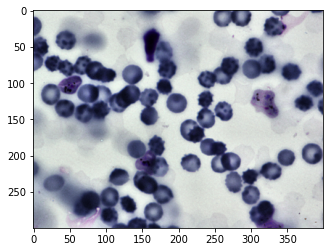

In [4]:
plt.imshow(df["image"][0])

In [5]:
df['image'][0].shape

(300, 400, 3)

In [11]:
# label infected cells as 2
df['targets'] = df['targets'].apply(lambda x:{'boxes':x['boxes'], 'labels': 2-x['labels']})

In [6]:
df['targets'][0]['labels']

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [7]:
class MalariaDataset(Dataset): 
    def __init__(self, df, transform=None): 
        self.df = df
        self.transform = transform

    def __len__(self): 
        return len(self.df)

    def __getitem__(self, index): 
        image = self.df['image'][index]
        targets = self.df['targets'][index]
        if self.transform: 
            image = self.transform(image)
        return image, targets
        
def collate_fn(batch):
    images, targets = zip(*batch)
    images = torch.stack(list(images))
    boxes = list(targets)
    return images, targets

def get_loader(df, batch_size=32, transform=None): 
    dataset = MalariaDataset(df, transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, drop_last=True)

In [12]:
data = MalariaDataset(df, transform=transforms.ToTensor())

In [13]:
np.random.seed(1000)
n = len(df)
n_trn = int(n*0.7)
n_val = int(n*0.2)
train_set, val_set, test_set = torch.utils.data.random_split(dataset=data, lengths=[n_trn, n_val, n-n_trn-n_val])

torch.Size([3, 300, 400])


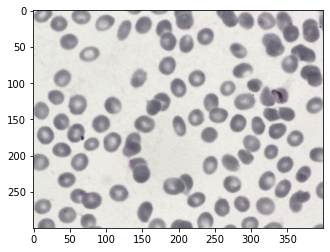

In [14]:
for i, j in val_set:
  print(i.shape)
  plt.imshow(np.transpose(i.numpy(),(1,2,0)))
  break

In [8]:
data_dir = pathlib.Path("/content/drive/MyDrive/APS360/Data/Yolo")

In [15]:
loader1 = DataLoader(val_set, shuffle=False, batch_size=2, collate_fn=collate_fn, drop_last=True)
for i, (img, targets) in enumerate(loader1):
  print(i)
  print(img.shape)
  # print(targets)
  break

0
torch.Size([2, 3, 300, 400])


## Helper Functions

In [9]:
def show_bound_boxes(image, boxes, labels):
    fig, ax = plt.subplots()
    ax.imshow(image)
    plt.title("Bounding Boxes")
    for box, label in zip(boxes, labels):
        color = "green" if label == 1 else "red"
        width, height = box[2] - box[0], box[3] - box[1]
        bounding_box = patches.Rectangle((box[0], box[1]), width, height ,edgecolor=color, facecolor='none')
        ax.add_patch(bounding_box)

In [10]:
def to_int(targets):
  boxes = targets['boxes']
  lbls = targets['labels']
  new = lbls.type(torch.LongTensor)
  return {'boxes':boxes, 'labels':new}

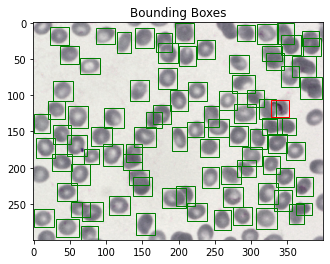

In [16]:
for i, (img, targets) in enumerate(loader1):
  img = np.transpose(img[0].numpy(), [1,2,0])
  box = targets[0]['boxes']
  lbl = targets[0]['labels']
  show_bound_boxes(img, box, lbl)
  break

# yolo

## backbone

In [ ]:
class basicBlock(nn.Module):
  def __init__(self, in_channel, out_channel, stride=1, downsample=None):
    super(basicBlock, self).__init__()
    self.layers = nn.Sequential(
        nn.Conv2d(in_channel, out_channel, stride=stride),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channel, out_channel),
        nn.BatchNorm2d(out_channel),
        )
    self.downsample = downsample

  def forward(self, x):
    x_prev = x
    out = self.layers(x)
    if self.downsample is not None:
      x_prev = self.downsample(x)
    out = F.relu(out + x_prev)
    return out

In [ ]:
class ResNet(nn.Module):
  def __init__(self, layers):
    super(ResNet, self).__init__():

    self.layer1 = Block()

## yo

In [20]:
class SPP(nn.Module): #spatial pyramid pool
  def __init__(self):
    super().__init__()
    self.pool1 = nn.MaxPool2d(5, stride=1, padding=2),
    self.pool2 = nn.MaxPool2d(9, stride=1, padding=4),
    self.pool3 = nn.MaxPool2d(13, stride=1, padding=6),
    
  def forward(self, x):
    out1 = self.pool1(x)
    out2 = self.pool2(x)
    out3 = self.pool3(x)
    out = torch.cat([x, out1, out2, out3], dim=1)
    return out

In [35]:
from torchvision.models import resnet18

class Yolo(nn.Module):
  def __init__(self, size_in=(300,400), num_classes=2, stride=20, threshold=0.1, backbone=None):
    super().__init__()
    self.name = f"yolo_cls{num_classes}_std{stride}"
    self.training = True

    self.size_in = size_in
    self.num_classes = num_classes
    self.threshold = threshold
    # self.num_boxes = self.num_boxes # boxes generated each grid cell
    self.stride = stride # size of grid cells
    # self.train = True

    grid_size, self.grid = self.gt_grid(size_in, stride) #get grid 
    # self.size_out = grid_size[0]*grid_size[1] * (5*num_boxes+num_classes)
    self.size_out = 5 + num_classes  # 1 for object/background, 4 for bounding box

    if backbone is None:
        self.backbone = resnet18(pretrained=True)
    else:
        self.backbone = backbone
    self.ch1 = 512 # backbone output channel

    self.neck = nn.Sequential(
            SPP(),
            nn.Conv2d(self.ch1*4, self.ch1, 1), #conv with kernel 1 to compress 
            nn.BatchNorm2d(self.ch1),
            nn.LeakyReLU(0.1, inplace=True)
        )

    self.head = nn.Sequential( # detection head
        nn.Conv2d(self.ch1, 256, 1), 
        nn.LeakyReLU(0.1, inplace=True),
        nn.Conv2d(256, 512, 3, padding=1), 
        nn.LeakyReLU(0.1, inplace=True),        
        nn.Conv2d(512, 256, 1), 
        nn.LeakyReLU(0.1, inplace=True),        
        nn.Conv2d(256, 512, 3, padding=1), 
        nn.LeakyReLU(0.1, inplace=True),
    )

    self.pred = nn.Conv2d(512, self.size_out, 1)

  def loss(objectness, bbox, classes, target):
    conf_criterion = nn.MSEwithLogitLoss()
    box_criterion = nn.MSEwithLogitLoss()
    class_criterion = nn.CrossEntropyLoss()
    
    target_obj = target[:,:,:1] # .contiguous().view(shape[0], shape[1], 1)
    target_box = target[:,:,1:5]
    target_label = target[:,:,5:]

    batch_size = objectness.size(0)

    conf_loss = conf_criterion(objectness, target_obj)
    
    class_loss = class_criterion(classes, target_label)
    # weighted average with objectness
    class_loss = torch.sum(class_loss * objectness) /batch_size
    
    # txty_loss = torch.sum(torch.sum(txty_loss_function(pred_txty, gt_txty), dim=-1) * gt_box_scale_weight * gt_obj) / batch_size
    bbox_loss = box_criterion(bbox, target_box)

    return conf_loss + bbox_loss + class_loss

  def forward(self, x, target=None):
    assert (not self.training) or target is not None

    i, j, x = self.backbone(x)
    x = self.neck(x)
    x = self.convs(x)

    pred = self.pred(x)
    pred = pred.view(x.shape[0], self.size_out, -1).permute(0,2,1)

    shape = pred.shape
    objectness = pred[:,:,:1] # .contiguous().view(shape[0], shape[1], 1)
    bbox = pred[:,:,1:5]
    classes = pred[:,:,5:]

    if self.training:
      return self.loss(objectness, bbox, classes, target)
    else: 
      # return {'boxes':bbox, 'labels':classes}
      # use NMS here
      return objectness, bbox, classes

  def gt_grid(self, size_in, stride):
    x, y = size_in
    grid_size = [x//self.stride, y//self.stride]

    ranges = [torch.arange(grid_size[0]), torch.arange(grid_size[1])]
    grid_x, grid_y = torch.meshgrid(ranges)
    grid = torch.stack([grid_x, grid_y], dim=-1)
    grid = grid.view(1, -1, 2)
    return grid_size, grid

  def train(self):
    self.training = True
  def eval(self):
    self.training = False



In [36]:
m1 = Yolo()
m1.eval()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [41]:
df['image'][0].shape

(300, 400, 3)

In [45]:
img = torch.Tensor(df['image'][0]).permute(2,0,1)

In [46]:
m1(img)

ValueError: ignored

In [ ]:
#test

boxes = np.array(
    [[2, 3, 4, 3],
     [1, 2, 3, 4],
     [4, 3, 1, 2]]
)
scores = np.array([1, 3, 2])

def nms(boxes, scores, threshold=0.5):
    x1, y1, x2, y2 = boxes[:,0], boxes[:,1], boxes[:,2], boxes[:,3]
    print(x1)
    areas = (x2-x1)*(y2-y1)
    order = scores.argsort()[::-1] #indeices in descending order
    print(order)
    temp = []
    while order.size>0:
       i = order[0] # highest score box
       temp.append(boxes[i])
       print(temp)
       order = order[1:]
       xx1 = np.maximum(x1[i], x1[order])
       
       yy1 = np.maximum(y1[i], y1[order])
       xx2 = np.minimum(x2[i], x2[order])
       yy2 = np.minimum(y2[i], y2[order])
       print(xx1, yy1, xx2, yy2)
       inter = np.maximum(0, xx2-xx1)* np.maximum(0, yy2-yy1)
       print(inter)
       union = areas[i] + areas[order] - inter
       print(union)
       index = np.where(inter/union < threshold)[0]
       print(index)
       order = order[index+1]
    return temp

nms(boxes, scores)

[2 1 4]
[1 2 0]
[array([1, 2, 3, 4])]
[4 2] [3 3] [1 3] [2 3]
[0 0]
[7 4]
[0 1]


IndexError: ignored

## train

In [ ]:
def format_target(target):
    boxes = target['boxes']
    labels = target['labels']
    # negative samples?
    

In [ ]:
def train_yolo(model, batch_size=1, learning_rate=0.001, step_size=3, epoches = 10, start=0):    
    model.train() 
    torch.manual_seed(1000)
    model_path = f"/content/drive/MyDrive/APS360/yolo/models/label1_2/{model.name}_bs{batch_size}_lr{learning_rate}"
    
    train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size, collate_fn=collate_fn, drop_last=True)
    val_loader = DataLoader(val_set, shuffle=True, batch_size=batch_size, collate_fn=collate_fn, drop_last=True)
    

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.Adam(params, lr=learning_rate)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3)
    

    train_loss = np.zeros(epoches)
    val_error = np.zeros(epoches)
    n = len(train_loader)
    
    for epoch in range(epoches):
        epoch_loss = 0 
        for i, (images, targets) in enumerate(train_loader): 
            #TODO format targets
            loss = model(images, targets) # in train mode output is targets
  
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i<10 or i%30==0:
                print(f'{i}/{n}, loss: {loss.item():.4f}')
            epoch_loss += loss.item()
            
        lr_scheduler.step()   # update lr

        train_loss[epoch] = epoch_loss / batch_size
        print(f"Epoch {epoch+start}/{epoches} Loss: {loss.item():.4f}")

        torch.save(model.state_dict(), model_path+f"epoch_{epoch+start}")

    return model_path

tensor([2., 1., 4.])


TypeError: ignored

In [ ]:
def combine(targets):
  boxes = targets['boxes']
  labels = targets['labels']
  new = []
  for box, label in zip(boxes, labels):
    new.append([label, box[0], box[1], box[2], box[3]])
  return torch.Tensor(new)

# fold this


In [ ]:
class RCNN(nn.module):
  def __init__(self, num_classes=2):
    super(RCNN, self).__init__()
    self.rpn = RPN()
    self.roi_pool = RoiPool()
    self.encoder = 
    self.fcs = nn.Sequential(
        nn.Linear()
        )
    
  def forward(self, x, targets=None):
    if targets is None:
      out = 
      return out
    else:
      loss = 
      return loss

In [ ]:
resnet = torchvision.models.resnet101(pretrained=True)

In [ ]:
print(resnet)

In [ ]:
class do_nothing(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self, x):
    return x

In [ ]:
# get rid of last layers
resnet.layer4 = resnet.avgpool = resnet.fc = do_nothing()

class RPN(nn.module):
  def __init__(self, anchor_scales=[32], num_classes=2, encoder=resnet):
    super(RPN, self).__init__()
    type_anchors = len(anchor_scales)
    self.path = "/content/drive/MyDrive/APS360/Models/RPN"
    self.encoder = encoder
    # pixel conv
    self.score = nn.Conv2d(1024, type_anchors*3*2, 1, same_padding=True)
    self.propose = nn.Conv2d(1024, type_anchors*3*4, 1, same_padding=True)
    
  def forward(self, image, targets=None):
    features = self.encoder()
    class_score = self.score(features)
    # softmax
    proposals = self.propose(features)
    # non max suppress
    proposals = self.suppress(proposals)

  def supress(self, boxes, threshold=0.4):
    x1, y1, x2, y2 = boxes[:,0], boxes[:,1], boxes[:,2], boxes[:,3]
    areas = (x2-x1)*(y2-y1)
    # IoU = inter/union = inter/(area1+area2-inter)
    
    
  def intersection(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter = max(0, x2-x1)* max(0, y2-y1)
    return inter